# What's happening in this notebook?

Objective:

Data from SNAP, composed of people who have sent emails to each other.  

    - People email to each other, and thus make edges.
    - Each person belongs in a specific faculty/label

Can we cluster the people into the original labels using only edge topology and spectral clustering?

In this notebook we have:

1. Read the data
2. Wrangled the data
    - Directed network --> Undirected network
    - Deleted 19/1005 nodes (unconnected) for simplicity (they only sent emails to themselves??)
3. Computed the adjacency matrix
4. Implement spectral clustering (embedding)
    - Compute Laplacian
    - Use eigenvalue decomposition and get the n first eigenvectors (the embedding)
    - Cluster the nodes using the embedding
        - KMeans
        - Discretization (what sklearn uses under the hood, it is way better)
5. Plotted the graphs of the original labels and the predicted ones
6. Evaluated the results numerically
    - Confusion matrix
    - Adjusted rand score

--> Compare spectral clustering on this dataset by:
- Kmeans vs discretization
- Laplacian vs Normalized Laplacian vs the other normalized Laplacian
- --> 6 models to compare

--> Not the best results but the original data is bad thus ok for us :)


TODO:

- [x] Implement the other Laplacian methods (easy)
- [x] For loop evaluate all the methods together and make results table
- [ ] Save plots for report
- [ ] Write the report

## Imports

In [74]:
# Data wrangle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Sklearn
from scipy.linalg import fractional_matrix_power
from sklearn.cluster._spectral import discretize
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score

# Plotting
import igraph
import seaborn as sns; sns.set()


## Functions for data wrangle and clustering

In [75]:
def read_data(edgeFile,labelFile):
    """Reads the data into numpy arrays

    Parameters
    ----------
    edgeFile : str
        filename for the file with the edges
    labelFile : str
        filename for the file with the edges and their labels

    Returns
    -------
        np.array
        Numpy arrays of the resulting edges, and the ground truth labels
    """
    # Read the edges
    with open(edgeFile) as file:
        edges = file.readlines()
        edges = np.array([list(map(int,line.rstrip().split(" "))) for line in edges])
    # Make the graph to an undirected graph
    edges = np.unique(np.concatenate((edges,np.flip(edges, axis=1)),axis=0),axis=0)

    # Read the labels
    with open(labelFile) as file:
        g_truth_original = file.readlines()
        g_truth_original = np.array([list(map(int,line.rstrip().split(" "))) for line in g_truth_original])
    
    return edges,g_truth_original

In [76]:
def create_adjacency_matrix(edges,g_truth_original):
    """Creates the adjacency matrix A. Deletes unconnected nodes.


    Parameters
    ----------
    edges : np.array
    g_truth_original : np.array

    Returns
    -------
    np.array
        Adjancency matrix and the ground truth without the unconnected edges
    """
    size = len(set([n for e in edges for n in e])) 
    A_original = np.array([[0]*size for _ in range(size)])

    for sink, source in edges:
        if sink != source: # No self-edges
            A_original[sink][source] = 1

    # Find unconnected nodes
    def find_unconnected_nodes(A_original):
        bool_unconnected = np.logical_and(A_original.sum(axis=0)==0,A_original.sum(axis=1)==0)
        uncon_nodes = [i for i, x in enumerate(bool_unconnected) if x]
        return uncon_nodes
    uncon_nodes = find_unconnected_nodes(A_original)

    # Delete unconnected nodes, shift labels to accommodate this
    A = np.delete(np.delete(A_original,uncon_nodes,axis=1),uncon_nodes,axis=0)
    g_truth = np.delete(g_truth_original,uncon_nodes,axis=0)
    g_truth[:,0] = np.arange(0,A.shape[0])

    return A, g_truth

In [77]:
def compute_laplacian(A,type='normalized'):
    """Computes the laplacian from the adjancency matrix

    Parameters
    ----------
    A : np.array
        Adjancency matrix

    Returns
    -------
    np.array    
        Laplacian matrix
    """
    D = np.diag(A.sum(axis=1))
    L = D-A

    if type=='normalized/Lrw':
        # Shi and Malik 2000 I-D^-1*A
        L= np.eye(A.shape[0], dtype=int)-np.linalg.inv(D) @ A
    if type=='normalized/Lsym':
        # Ng, Jordan, Weiss 2002
        L= np.eye(A.shape[0], dtype=int)-fractional_matrix_power(D, -0.5) @ A @ fractional_matrix_power(D, -0.5)
        L = L / np.abs(L).sum(axis=1)[:,np.newaxis]
    return L

In [78]:
def my_spectral_embedding(A,n_components,laplacian_type = 'normalized'):
    """Embedds the adjacency matrix into the eigenvectors of the Laplacian

    Parameters
    ----------
    A : np.array    
        Adjacency matrix    
    n_components : int
        Number of eigenvectors to keep. By default keeps the first eigenvector.

    Returns
    -------
    np.array
        The n first (smallest) eigenvectors and values, sorted by eigenvalues.
    """

    L = compute_laplacian(A,type=laplacian_type)
    # eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(L)

    # sort these based on the eigenvalues
    vecs = np.real(vecs[:,np.argsort(vals)])
    vals = np.real(vals[np.argsort(vals)])
    return vecs[:,:n_components],vals[:n_components]

def my_clustering(X,n_clusters=42,how='kmeans'):
    """Clusters data using either kmeans or discretization

    Parameters
    ----------
    X : np.array
        This can be anything, but preferably the eigenvector matrix of the Laplacian
    n_clusters : int, optional
        , by default 42
    how : Clustering method, optional
        , by default 'kmeans'

    Returns
    -------
    np.array    
        Predicted labels for the observations (nodes)
    """
    if how=='kmeans':
        kmeans = KMeans(n_clusters=n_clusters)
        preds = kmeans.fit_predict(X)
    elif how == 'discretize':
        preds = discretize(X[:,:n_clusters-1])
    return preds


In [79]:
def pred_pipeline(A,n_components,laplacian_type,cluster_method):
    vecs,vals = my_spectral_embedding(A,n_components=n_components,laplacian_type=laplacian_type)
    preds = my_clustering(vecs,n_clusters=42,how=cluster_method)
    results = np.append(np.arange(0,len(preds)).reshape(-1,1), preds.reshape(-1,1), axis=1)
    results = results[results[:,0].argsort()]
    return results

### Create adjacency matrix

In [80]:
edges,g_truth_original = read_data(edgeFile=r'email-Eu-core.txt',labelFile=r'email-Eu-core-department-labels.txt')
A,g_truth = create_adjacency_matrix(edges,g_truth_original)

### Compute the results

In [99]:
results = pred_pipeline(A,n_components=32,laplacian_type='normalized/Lsym',cluster_method='discretize')
np.savetxt('test.txt', results,fmt='%i')
adjusted_rand_score(results[:,1], g_truth[:,1])

0.5734131634861224

## Looping over all methods

In [82]:
# Takes 6 minutes, not necessary to always run. normalized/Lsym  n_components = 32 is the best method.
loop_models = True
if loop_models:
    full_results = {}
    for l_type in ['unnormalized','normalized/Lrw','normalized/Lsym']:
        for method in ['kmeans','discretize']:
            for n_components in list(range(2,80,2)):
                predictions = pred_pipeline(A,n_components=n_components,laplacian_type=l_type,cluster_method=method)
                score = adjusted_rand_score(predictions[:,1], g_truth[:,1])
                full_results[l_type+"_"+method+"_"+str(n_components)] = score
                if n_components % 10 == 0:
                    print('Type: '+l_type+", method: "+method+", n_components: "+str(n_components)+". Score: "+str(np.around(score,5)))

Type: unnormalized, method: kmeans, n_components: 10. Score: 0.01715
Type: unnormalized, method: kmeans, n_components: 20. Score: 0.00165
Type: unnormalized, method: kmeans, n_components: 30. Score: 0.00093
Type: unnormalized, method: kmeans, n_components: 40. Score: 0.00086
Type: unnormalized, method: kmeans, n_components: 50. Score: 0.00048
Type: unnormalized, method: kmeans, n_components: 60. Score: 0.00056
Type: unnormalized, method: kmeans, n_components: 70. Score: 0.0008
Type: unnormalized, method: discretize, n_components: 10. Score: 0.00113
Type: unnormalized, method: discretize, n_components: 20. Score: 0.00059
Type: unnormalized, method: discretize, n_components: 30. Score: 0.00207
Type: unnormalized, method: discretize, n_components: 40. Score: 0.00217
Type: unnormalized, method: discretize, n_components: 50. Score: 0.0022
Type: unnormalized, method: discretize, n_components: 60. Score: 0.00206
Type: unnormalized, method: discretize, n_components: 70. Score: 0.00222
Type: no

In [83]:
# if loop_models:
#     df_results = pd.DataFrame.from_dict(full_results,orient='index').sort_values(by=0,ascending=False)
#     plt.figure(figsize=(30, 10))
#     plt.bar(df_results.index, df_results[0]);
#     plt.xticks(rotation=45,fontsize=8);

#     plt.ylabel('Adjusted Rand Score')
#     plt.savefig('Figures/model_scores.png')
#     plt.show()


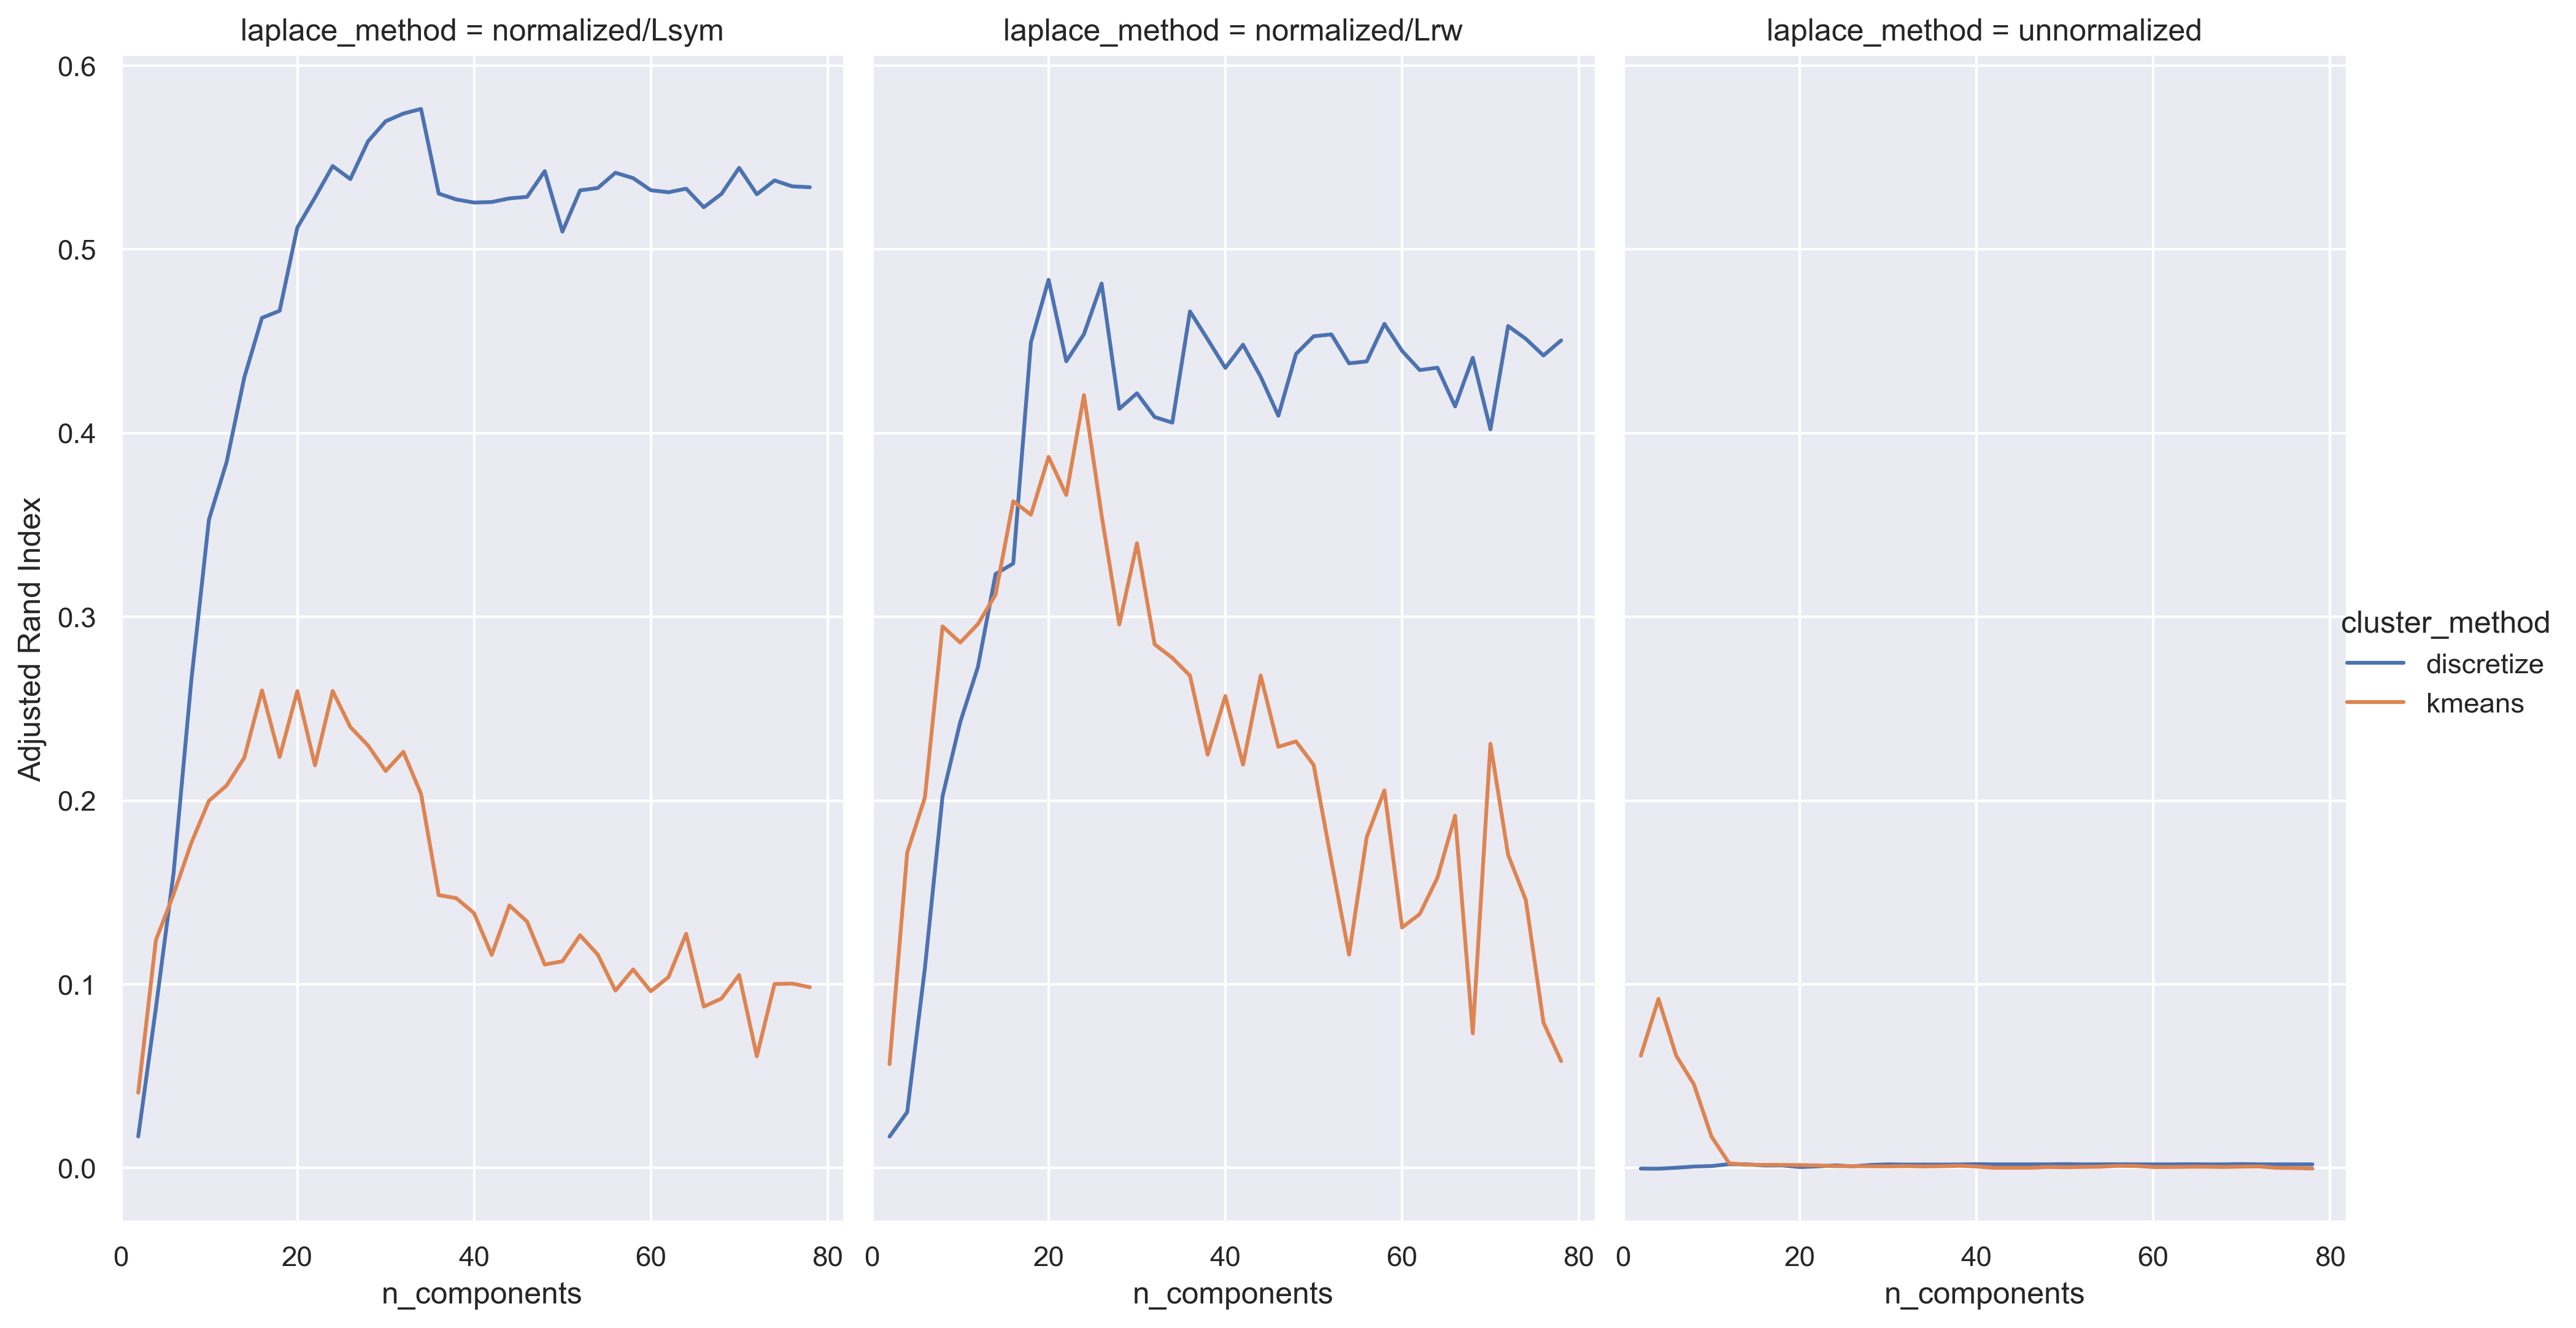

In [85]:
if loop_models:
    sns.set(rc={"figure.dpi":300, 'savefig.dpi':1000})
    df_results = pd.DataFrame.from_dict(full_results,orient='index').sort_values(by=0,ascending=False).reset_index()
    # df_results['index'] = df_results['index'].apply(lambda x: x.replace('normalized/Lrw', "normalized/Lsym"))
    df_results[['laplace_method','cluster_method','n_components']] = df_results['index'].str.split("_",expand=True)
    df_results['n_components'] = df_results['n_components'].astype(int)

    # plt.figure(figsize=(25, 20))
    g = sns.relplot(x='n_components', y=0, col="laplace_method",hue='cluster_method',
                data=df_results, kind="line")
    # plt.xticks(rotation=45,fontsize=8);
    g.set_axis_labels("n_components", "Adjusted Rand Index")
    g.set(xlim=(0, None))
    # g.set_xticklabels(fontsize=8)
    g.fig.set_figwidth(14)
    g.fig.set_figheight(8)
    plt.savefig('Figures/model_scores.eps', format='eps')
    plt.show()

## Plot graphs of both networks

In [11]:
def get_approximate_labels(real,predicted):
    " Tries to match the cluster labels of predictions to the ground truth"
    cm = confusion_matrix(real,predicted)
    cm_argmax = cm.argmax(axis=0)
    y_pred_ = np.array([cm_argmax[i] for i in predicted])
    return y_pred_

def plot_graph(A,c_ids):
    "Plots the network and colors the nodes with c_ids labels"
    g = igraph.Graph.Adjacency(A)
    random.seed(1234)
    # Color each vertex according to the ground truth
    id_gen = igraph.UniqueIdGenerator()
    color_indices = [id_gen.add(value) for value in c_ids]
    palette = igraph.ClusterColoringPalette(len(id_gen))
    colors = [palette[index] for index in color_indices]

    fig, ax = plt.subplots(figsize=(15,10))
    igraph.plot(g, vertex_color=colors,edge_color=(0.87,0.87,0.87,0.3),edge_arrow_size=0,edge_width=0.7,layout='lgl', target=ax)

def plot_confusion(real,y_pred_):
    cm_ = confusion_matrix(real, y_pred_)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(cm_, annot=True, fmt="d", cmap="Blues",ax=ax)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    ax.set_facecolor('green')

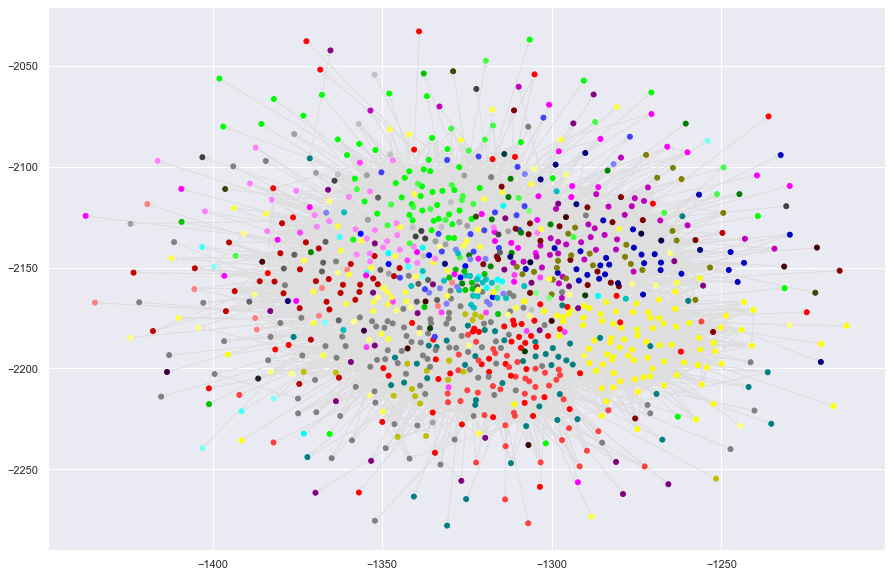

In [12]:
plot_graph(A,g_truth[:,1])
plt.savefig('Figures/original_network.png')

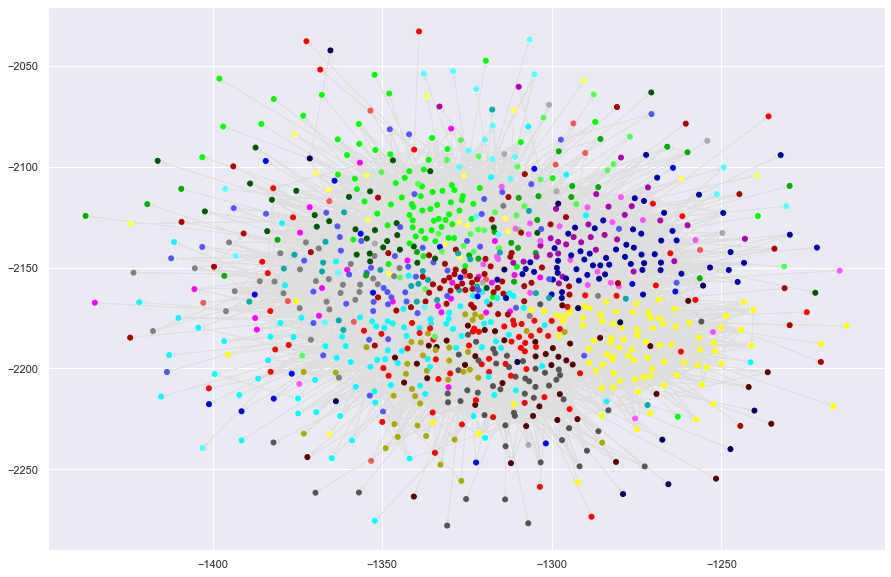

In [13]:
y_pred_ = get_approximate_labels(g_truth[:,1],results[:,1])
plot_graph(A,y_pred_)
plt.savefig('Figures/result.png')

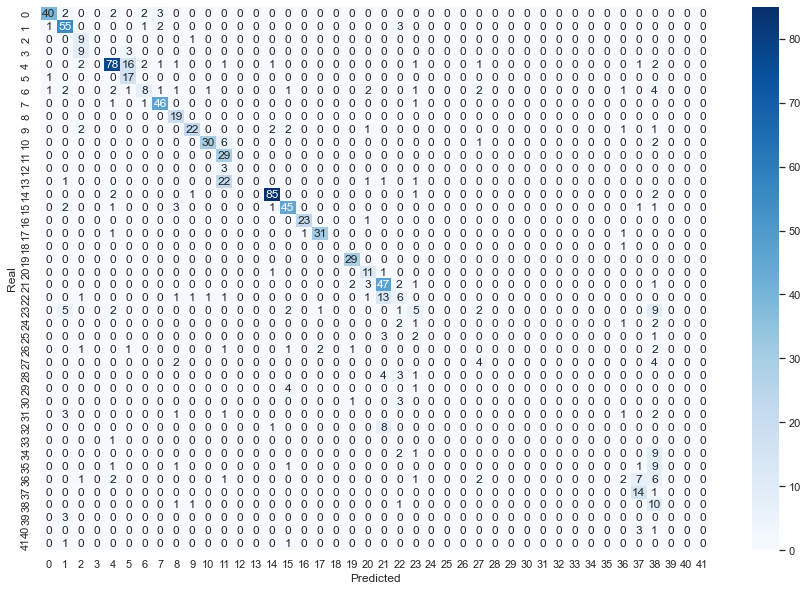

In [14]:
plot_confusion(g_truth[:,1],y_pred_)

### Degree distribution

In [15]:
D = np.diag(A.sum(axis=1))

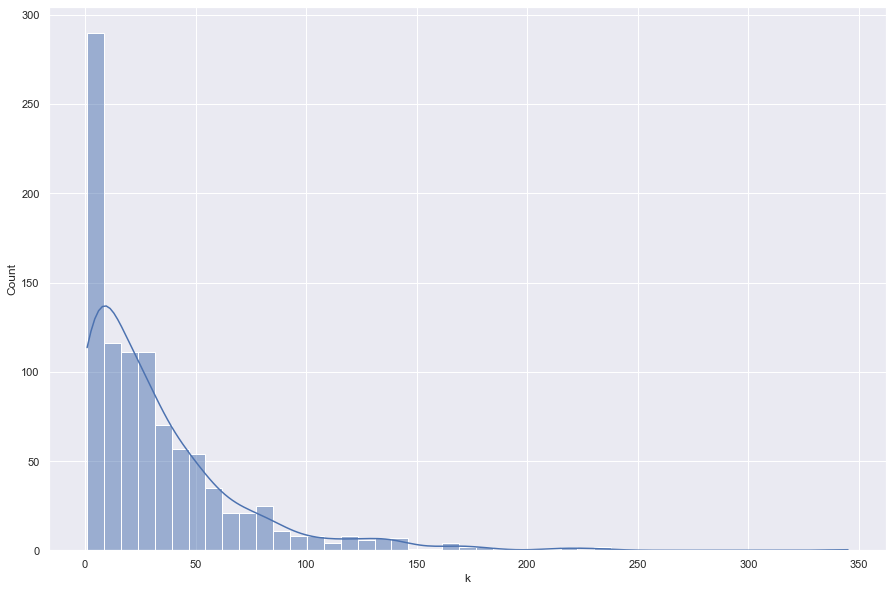

In [16]:
plt.figure(figsize=(15,10))
sns.histplot(np.diag(D), kde=True)
plt.xlabel('k')
plt.savefig('Figures/degree_dist.png')